In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import DyNetSet as dns
import numpy as np
import random
nx.__version__

'3.3'

In [ ]:
def find_affected_nodes(network, source, target):
    """
    Finds the subgraph affected by the addition of an edge (source -> target).
    The affected nodes are those reachable from target and those that can reach source.
    
    Parameters:
    - network: The DAG where the cycle is checked.
    - source: The start node of the new edge.
    - target: The end node of the new edge.
    
    Returns:
    - affected_nodes: A set of nodes that belong to the cycles.
    """
    # Find nodes reachable from target (forward search)
    reachable_from_target = set(nx.descendants(network, target))
    reachable_from_target.add(target)

    # Find nodes that can reach source (reverse search)
    can_reach_source = set(nx.ancestors(network, source))
    can_reach_source.add(source)

    # The affected nodes are those in the intersection of both sets
    affected_nodes = reachable_from_target & can_reach_source
    return affected_nodes

def find_cycles_tarjan(network, affected_nodes, source, target, edge_weight):
    """
    Identifies all cycles using Tarjan's SCC algorithm and the minimum weight 
    among all edges in those cycles.
    
    Parameters:
    - network: The current DAG.
    - affected_nodes: Nodes involved in cycles.
    - source: Start node of the new edge.
    - target: End node of the new edge.
    - edge_weight: The weight of the edge being added.

    Returns:
    - cycles: List of cycles (each cycle is a list of edges).
    - min_weight: Minimum weight among all cycle edges.
    """
    # Extract the affected subgraph
    subgraph = network.subgraph(affected_nodes).copy()

    # Add the new edge *safely*
    subgraph.add_edge(source, target, weight=edge_weight)

    # Find Strongly Connected Components (SCCs)
    sccs = list(nx.strongly_connected_components(subgraph))

    # Identify cycles (SCCs with more than one node)
    cycles = []
    min_weight = float('inf')

    for scc in sccs:
        if len(scc) > 1:  # A cycle exists in this SCC
            cycle_nodes = list(scc)
            cycle_edges = [
                (u, v) for u in cycle_nodes for v in cycle_nodes if subgraph.has_edge(u, v)
            ]
            cycles.append(cycle_edges)

            # Find the minimum edge weight in this cycle
            for u, v in cycle_edges:
                weight = subgraph[u][v]['weight']
                min_weight = min(min_weight, weight)

    return cycles, min_weight if cycles else None

def remove_min_weight_edges_and_adjust(network, cycles, min_weight):
    """
    Removes all edges with the minimum weight from the cycles and subtracts
    the minimum weight from remaining edges in those cycles.

    Parameters:
    - network: The DAG where cycles are checked.
    - cycles: List of cycles detected.
    - min_weight: Minimum weight found in the cycles.
    """
    if not cycles or min_weight is None:
        return  # Nothing to remove

    edges_to_remove = set()

    for cycle_edges in cycles:
        # Remove edges with min_weight and adjust the rest
        for u, v in cycle_edges:
            if network.has_edge(u, v):  # Check if edge still exists
                if network[u][v]['weight'] == min_weight:
                    edges_to_remove.add((u, v))  # Mark for removal
                else:
                    network[u][v]['weight'] -= min_weight  # Adjust weight

    # Remove all edges with the minimum weight
    network.remove_edges_from(edges_to_remove)

def cycle_cancelling(edge, network):
    """
    Adds an edge to the network and removes all cycles introduced by it using Tarjan's SCC.

    Parameters:
    - edge: The edge (u, v, {'weight': w}) to be added.
    - network: The DAG where the cycle is checked.

    Returns:
    - network: The updated DAG after cycle cancellation.
    """
    source, target, data = edge
    edge_weight = data['weight']  # Extract weight safely

    # Add the new edge to the network
    network.add_edge(source, target, **data)

    # Identify affected nodes
    affected_nodes = find_affected_nodes(network, source, target)
    
    if not affected_nodes:
        return network  # No cycles can exist, return early

    while True:
        # Find cycles and minimum weight in those cycles using Tarjan's SCC
        cycles, min_weight = find_cycles_tarjan(network, affected_nodes, source, target, edge_weight)
        
        if not cycles:
            break  # No more cycles

        # Remove min-weight edges and adjust remaining cycle edges
        remove_min_weight_edges_and_adjust(network, cycles, min_weight)

    return network


DiGraph with 26 nodes and 32 edges 32.0


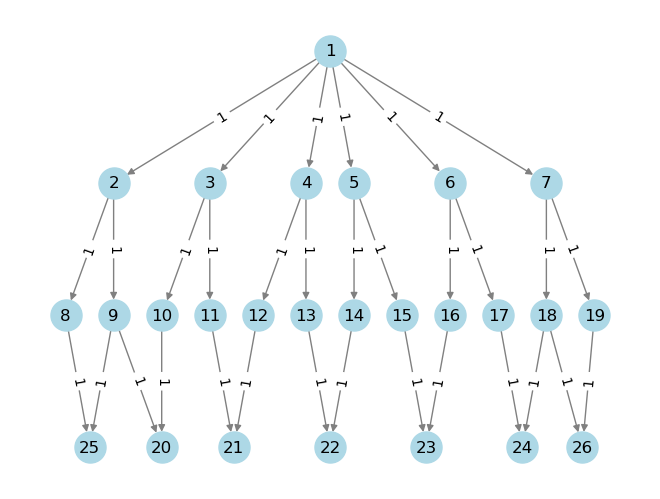

In [ ]:
# Tree Graph
edge_bundle = [
    # first level
    (1,2,{'weight':1}),
    (1,3,{'weight':1}),
    (1,4,{'weight':1}),
    (1,5,{'weight':1}),
    (1,6,{'weight':1}),
    (1,7,{'weight':1}),
    # second level
    (2,8,{'weight':1}),
    (2,9,{'weight':1}),
    (3,10,{'weight':1}),
    (3,11,{'weight':1}),
    (4,12,{'weight':1}),
    (4,13,{'weight':1}),
    (5,14,{'weight':1}),
    (5,15,{'weight':1}),
    (6,16,{'weight':1}),
    (6,17,{'weight':1}),
    (7,18,{'weight':1}),
    (7,19,{'weight':1}),
    # third level
    (8,25, {'weight':1}),
    (9,25, {'weight':1}),
    (9,20, {'weight':1}),
    (10,20, {'weight':1}),
    (11,21, {'weight':1}),
    (12,21, {'weight':1}),
    (13,22, {'weight':1}),
    (14,22, {'weight':1}),
    (15,23, {'weight':1}),
    (16,23, {'weight':1}),
    (17,24, {'weight':1}),
    (18,24, {'weight':1}),
    (18,26, {'weight':1}),
    (19,26, {'weight':1}),
            ]
#for e in edge_bundle:
T = nx.DiGraph()
T.add_edges_from(edge_bundle)
print(T, T.size('weight'))
# Uses Graphviz for tree layout
pos = nx.nx_agraph.graphviz_layout(T, prog="dot") 
nx.draw(T, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray")
# Draw edge labels (weights)
edge_labels = {(u, v): T[u][v]['weight'] for u, v in T.edges()}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels, font_color='black', font_size=10);


[(1, 2, {'weight': 1}), (2, 9, {'weight': 1}), (9, 20, {'weight': 1})]
[(1, 3, {'weight': 1}), (3, 10, {'weight': 1}), (10, 20, {'weight': 1})]
DiGraph with 4 nodes and 3 edges 3.0
[(1, 2, {'weight': 1}), (1, 3, {'weight': 1}), (1, 4, {'weight': 1}), (6, 16, {'weight': 1})]
[(1, 5, {'weight': 1}), (1, 6, {'weight': 1}), (1, 7, {'weight': 1}), (2, 8, {'weight': 1}), (2, 9, {'weight': 1}), (3, 10, {'weight': 1}), (3, 11, {'weight': 1}), (4, 12, {'weight': 1}), (4, 13, {'weight': 1}), (5, 14, {'weight': 1}), (5, 15, {'weight': 1}), (6, 17, {'weight': 1}), (7, 18, {'weight': 1}), (7, 19, {'weight': 1}), (8, 25, {'weight': 1}), (9, 25, {'weight': 1}), (9, 20, {'weight': 1}), (10, 20, {'weight': 1}), (11, 21, {'weight': 1}), (12, 21, {'weight': 1}), (13, 22, {'weight': 1}), (14, 22, {'weight': 1}), (15, 23, {'weight': 1}), (16, 23, {'weight': 1}), (17, 24, {'weight': 1}), (18, 24, {'weight': 1}), (18, 26, {'weight': 1}), (19, 26, {'weight': 1}), (26, 7, {'weight': 1})]


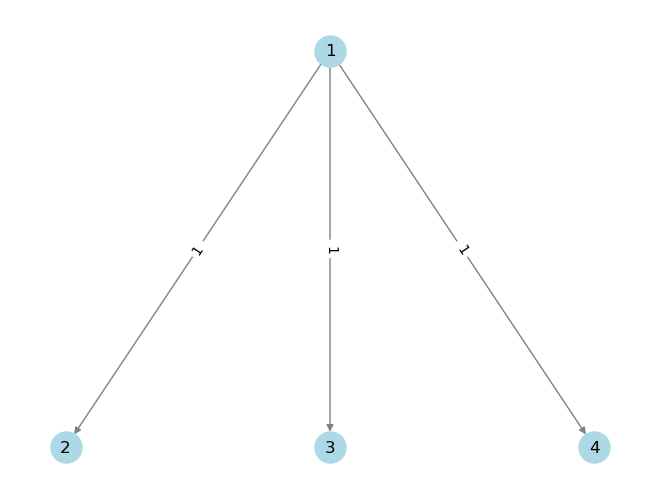

In [ ]:
# DAG sampling
dag_sg, sampled_edges = sample_connected_dag_using_union_find(T)
print(dag_sg, dag_sg.size("weight"))
# Uses Graphviz for tree layout
pos = nx.nx_agraph.graphviz_layout(dag_sg, prog="dot") 
nx.draw(dag_sg, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray")
# Draw edge labels (weights)
edge_labels = {(u, v): dag_sg[u][v]['weight'] for u, v in dag_sg.edges()}
nx.draw_networkx_edge_labels(dag_sg, pos, edge_labels=edge_labels, font_color='black', font_size=10);
print(sampled_edges)
# edges left outside
not_sampled_edges = [e for e in T.edges(data=True) if e not in sampled_edges]
# not_sampled_edges.append((25, 1, {'weight': 1}))
not_sampled_edges.append((26, 7, {'weight': 1}))
print(not_sampled_edges)

DiGraph with 26 nodes and 27 edges 27.0


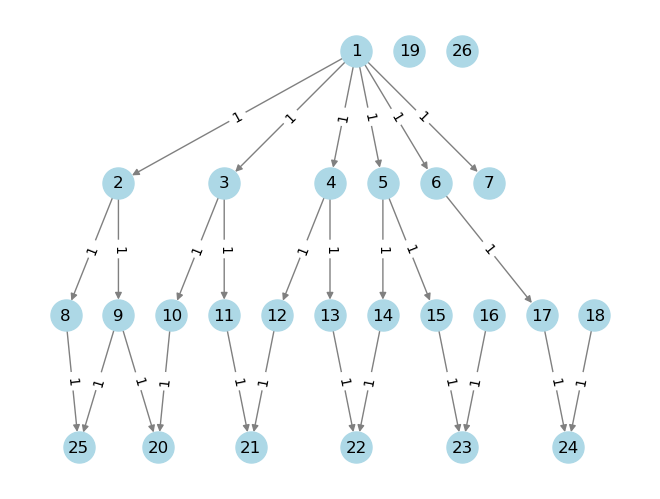

In [90]:
for e in not_sampled_edges:
    dag_sg = cycle_cancelling(e, dag_sg)
print(dag_sg, dag_sg.size('weight'))
# Uses Graphviz for tree layout
pos = nx.nx_agraph.graphviz_layout(dag_sg, prog="dot") 
nx.draw(dag_sg, pos, with_labels=True, node_size=500, node_color="lightblue", edge_color="gray")
# Draw edge labels (weights)
edge_labels = {(u, v): dag_sg[u][v]['weight'] for u, v in dag_sg.edges()}
nx.draw_networkx_edge_labels(dag_sg, pos, edge_labels=edge_labels, font_color='black', font_size=10);